# Figure5d: PHATE density plots (PDO21+SN38)

In [35]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scprep
import phate

from sklearn.decomposition import PCA
from MultiscaleEMD import MetricTree
import sklearn
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import gaussian_kde
import seaborn as sns

data_path = "/Users/mariaramos/Dropbox/Merged_files/"
#!ls -lah $data_path
file_name = "Metadata_final"

In [36]:
#Load metadata from file
raw_df = pd.read_pickle(data_path + file_name)

In [37]:
"""Variable: select for specific subsets of the data"""

cell_type_mask = ((raw_df['Cell_type'] == 'PDOs'))
patient_mask = ((raw_df['Patient'] == '21') | (raw_df['Patient'] == '27'))
culture_mask = (raw_df['Culture'] == 'PDO')
batch_mask = ((raw_df['Batch'] == 1))
plate_mask = ((raw_df['Plate'] == 'SLV'))
treatment_mask = (((raw_df['Treatment'] == 'DMSO')) | (raw_df['Treatment'] == 'S'))

data_masked = raw_df.loc[cell_type_mask & patient_mask & treatment_mask]
data_masked.index = np.arange (data_masked.shape[0])


In [38]:
#Clean-up: removing pPKCa to remove NaN values - downsample 

data_masked.drop('pPKCa', axis=1, inplace=True)
# data_masked = data_masked.sample(n=1000000, random_state=1, replace=False)
data_masked.index = np.arange (data_masked.shape[0])

#Creates a tag for normalization that includes Patient + Date
def col_join(arr):
    """ Joins columns of a dataframe into a single column with underscores """
    return "_".join(np.array(arr).astype("str"))
    
norm_tags = data_masked.iloc[:, -9:-7].T.apply(col_join).rename("Norm_tag")
df_with_tags = pd.concat([data_masked, norm_tags], axis=1)

#We need to split the data to normalise the numerical columns
data_for_norm = df_with_tags.iloc[:, :-10]
non_numerical = df_with_tags.iloc[:, -10:-1]

# Arcsinh transformation and batch normalisation
data_arcs = np.arcsinh(data_for_norm / 5)
data_centered = scprep.normalize.batch_mean_center(
    data_arcs.copy(), sample_idx=df_with_tags["Norm_tag"]
)

#Re-merge the non-numerical values to the normalised data
full_centered = pd.concat([data_centered, non_numerical], axis=1)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [39]:
# Build a canonical list of names for each sample so we can order by this in
# all subsequent processing

full_names = full_centered.iloc[:, -9:].T.apply(col_join).rename("Full_name")
df_with_names = pd.concat([full_centered, full_names], axis=1)

metadata = df_with_names.iloc[:, -10:]
data = full_centered.iloc[:, :-9]

full_data = pd.concat([metadata, data], axis=1)

In [40]:
mean_locs = (
    df_with_names.groupby(
        [
            "Culture",
            "Date",
            "Treatment",
            "Concentration",
            "Replicate",
            "Cell_type",
            "Patient",
            "Full_name",
            "Batch", 
            "Plate"
        ]
    )
    .mean()
)

meta = mean_locs.index.to_frame()

# Sorting is necessary so that np.unique works for labeling the samples on the tree
# meta contains one line per sample and the metadata table associated with that sample
meta = meta.reset_index(drop=True).sort_values("Full_name").reset_index(drop=True)

In [41]:
non_sig_markers = [
    "pHH3",
    "RFP",
    "mCHERRY",
    "Vimentin",
    "EpCAM",
    "CK18",
    "Pan_CK",
    "GFP",
    "IdU",
    "cCaspase_3",
    "Geminin",
    "pRB",
    "PLK",
    "CHGA",
    "CD90",
    "cPARP",
    "Cyclin_B1",
]
data_sig = data.drop(
    non_sig_markers,
    axis=1,
    inplace=False,
)
#Cell_type markers or problematic antibodies (cCaspase_3)
cell_type_markers = [
    "RFP",
    "mCHERRY",
    "Vimentin",
    "EpCAM",
    "CK18",
    "Pan_CK",
    "GFP",
    "CHGA",
    "CD90",
    "cCaspase_3"
]


data_all = data.drop(
    cell_type_markers,
    axis=1,
    inplace=False,
)

In [42]:
full_data_d = full_data.groupby(["Patient", "Treatment", "Culture"]).sample(n=4900, random_state = 1, replace = False)
data_all_d = full_data_d.iloc[:, 10:]
data_all_d = data_all_d.drop(cell_type_markers, axis=1, inplace=False)

In [43]:
phate_op = phate.PHATE(n_components = 2, knn=5, random_state=1)
data_all_phate = phate_op.fit_transform(data_all_d)
phate_all = pd.DataFrame(data_all_phate, index=data_all_d.index)

Calculating PHATE...
  Running PHATE on 39200 observations and 34 variables.
  Calculating graph and diffusion operator...
    Calculating KNN search...
    Calculated KNN search in 63.28 seconds.
    Calculating affinities...
    Calculated affinities in 0.41 seconds.
  Calculated graph and diffusion operator in 63.74 seconds.
  Calculating landmark operator...
    Calculating SVD...
    Calculated SVD in 2.88 seconds.
    Calculating KMeans...
    Calculated KMeans in 9.89 seconds.
  Calculated landmark operator in 14.03 seconds.
  Calculating optimal t...
    Automatically selected t = 18
  Calculated optimal t in 1.66 seconds.
  Calculating diffusion potential...
  Calculated diffusion potential in 0.30 seconds.
  Calculating metric MDS...
  Calculated metric MDS in 3.78 seconds.
Calculated PHATE in 83.52 seconds.


In [56]:
subset_21_s_pdo = phate_all.loc[(full_data_d['Treatment'] == 'S') & (full_data_d['Culture'] == 'PDO') & (full_data_d['Patient'] == '21')]
subset_21_s_pdof = phate_all.loc[(full_data_d['Treatment'] == 'S') & (full_data_d['Culture'] == 'PDOF') & (full_data_d['Patient'] == '21')]
subset_21_dmso_pdo = phate_all.loc[(full_data_d['Treatment'] == 'DMSO') & (full_data_d['Culture'] == 'PDO') & (full_data_d['Patient'] == '21')]
subset_21_dmso_pdof = phate_all.loc[(full_data_d['Treatment'] == 'DMSO') & (full_data_d['Culture'] == 'PDOF') & (full_data_d['Patient'] == '21')]


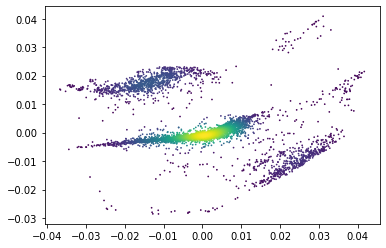

In [60]:
# PDO21 mono control
x_dmso_pdo = subset_21_dmso_pdo.iloc[:,0]
y_dmso_pdo = subset_21_dmso_pdo.iloc[:,1]
x_dmso_pdo = x_dmso_pdo.to_numpy()
y_dmso_pdo = y_dmso_pdo.to_numpy()

xy = np.vstack([x_dmso_pdo,y_dmso_pdo])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x, y, z = x_dmso_pdo[idx], y_dmso_pdo[idx], z[idx]

fig, ax = plt.subplots()
cmap = sns.color_palette("viridis", as_cmap=True)
ax.scatter(x, y, c=z, s=.5, cmap=cmap)

# plt.savefig('/Users/mariaramos/Dropbox/TAPE LAB/Manuscripts/Ramos Zapatero et al/Figures from Jupyter/PHATE_per_cell_99_H2O_mono.png', transparent=True)


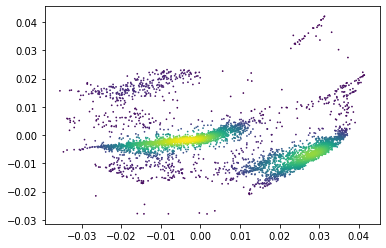

In [ ]:
# PDO21 mono SN-38
x_s_pdo = subset_21_s_pdo.iloc[:,0]
y_s_pdo = subset_21_s_pdo.iloc[:,1]
x_s_pdo = x_s_pdo.to_numpy()
y_s_pdo = y_s_pdo.to_numpy()

xy = np.vstack([x_s_pdo,y_s_pdo])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x, y, z = x_s_pdo[idx], y_s_pdo[idx], z[idx]

fig, ax = plt.subplots()
cmap = sns.color_palette("viridis", as_cmap=True)
ax.scatter(x, y, c=z, s=.5, cmap=cmap)

# plt.savefig('/Users/mariaramos/Dropbox/TAPE LAB/Manuscripts/Ramos Zapatero et al/Figures from Jupyter/PHATE_per_cell_99_H2O_mono.png', transparent=True)


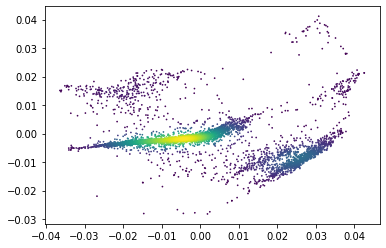

In [61]:
# PDO21 co control
x_dmso_pdof = subset_21_dmso_pdof.iloc[:,0]
y_dmso_pdof = subset_21_dmso_pdof.iloc[:,1]
x_dmso_pdof = x_dmso_pdof.to_numpy()
y_dmso_pdof = y_dmso_pdof.to_numpy()

xy = np.vstack([x_dmso_pdof,y_dmso_pdof])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x, y, z = x_dmso_pdof[idx], y_dmso_pdof[idx], z[idx]

fig, ax = plt.subplots()
cmap = sns.color_palette("viridis", as_cmap=True)
ax.scatter(x, y, c=z, s=.5, cmap=cmap)

# plt.savefig('/Users/mariaramos/Dropbox/TAPE LAB/Manuscripts/Ramos Zapatero et al/Figures from Jupyter/PHATE_per_cell_99_H2O_mono.png', transparent=True)


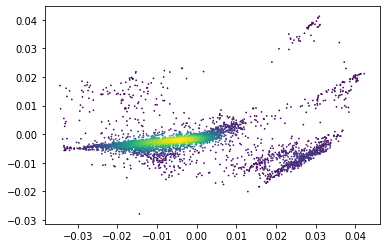

In [ ]:
# PDO21 co SN-38
x_s_pdof = subset_21_s_pdof.iloc[:,0]
y_s_pdof = subset_21_s_pdof.iloc[:,1]
x_s_pdof = x_s_pdof.to_numpy()
y_s_pdof = y_s_pdof.to_numpy()

xy = np.vstack([x_s_pdof,y_s_pdof])
z = gaussian_kde(xy)(xy)

idx = z.argsort()
x, y, z = x_s_pdof[idx], y_s_pdof[idx], z[idx]

fig, ax = plt.subplots()
cmap = sns.color_palette("viridis", as_cmap=True)
ax.scatter(x, y, c=z, s=.5, cmap=cmap)

# plt.savefig('/Users/mariaramos/Dropbox/TAPE LAB/Manuscripts/Ramos Zapatero et al/Figures from Jupyter/PHATE_per_cell_99_H2O_mono.png', transparent=True)
